In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data

import numpy as np
import pandas as pd
import xarray as xr
import bottleneck as bn
import iris

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# Scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [2]:
# Save filepaths
plotdir = '/g/data/w97/mg5624/plots/RF_project/'
datadir = '/g/data/w97/mg5624/RF_project/'

# Train Both Random Forest Models

## Load Training Data

In [3]:
data = pd.read_csv(datadir + 'training_data/training_data.csv')
data.dropna(axis=0, inplace=True)

# predictors with all variables
predictors_full = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_Annual_Precipitation', 'Runoff', 
                   'ENSO_index', 'IOD_index', 'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month']

# predictors of variables with timeseries back to 1950 or ealier (these go back to at least 1911)
predictors_long_ts = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_Annual_Precipitation', 'Runoff', 
                      'ENSO_index', 'IOD_index', 'Sin_month', 'Cos_month']

target = 'Drought'

## Check Dataset is Balanced

In [4]:
def check_if_dataset_is_balanced(data, target, balanced_threshold):
    """
    Checks if the data has balanced drought and no drought targets.
    Args:
    data (pd.DataFrame): Contains all training data
    predictors (list): list of the names of the predictor variables
    target (str): name of the target variable ('Drought')
    balanced_threshold (float): threshold for imbalance (e.g. 0.1)
    """
    y = data[target]
    
    class_counts = y.value_counts()
    
    class_proportions = class_counts / len(y)
    
    print("Class counts:\n", class_counts)
    print("\nClass proportions:\n", class_proportions)
    
    # Check if the dataset is balanced
    is_balanced = np.all(np.abs(class_proportions - 0.5) <= balanced_threshold)
    
    if is_balanced:
        print("\nThe dataset is balanced.")
    else:
        print("\nThe dataset is imbalanced.")

check_if_dataset_is_balanced(data, target, 0.1)

Class counts:
 Drought
1    515
0    420
Name: count, dtype: int64

Class proportions:
 Drought
1    0.550802
0    0.449198
Name: count, dtype: float64

The dataset is balanced.


## Train Model

In [5]:
X_full = data[predictors_full]
X_long_ts = data[predictors_long_ts]
y = data[target]

# Split the data into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.3, random_state=42)
X_train_long_ts, X_test_long_ts, y_train_long_ts, y_test_long_ts = train_test_split(X_long_ts, y, test_size=0.3, random_state=42)

# Create and train the Random Forest model
clf_full = RandomForestClassifier(n_estimators=500, random_state=42)
clf_full.fit(X_train_full, y_train_full)

clf_long_ts = RandomForestClassifier(n_estimators=500, random_state=42)
clf_long_ts.fit(X_train_long_ts, y_train_long_ts)

RandomForestClassifier(n_estimators=500, random_state=42)

## Test Model

In [6]:
# Predict on test data
y_pred_full = clf_full.predict(X_test_full)
y_pred_long_ts = clf_long_ts.predict(X_test_long_ts)

# Create an array of agreement between the two models
agree = y_pred_full == y_pred_long_ts
                                
# Display y_pred array
print("Predicted classes for the test data of the full model:\n", y_pred_full)
print("\nPredicted classes for the test data of the long timeseries model:\n", y_pred_long_ts)
print("\nPredicted agreement between the two models:\n:", agree)

# Calculate the number of droughts and non-droughts in y_pred
drought_count_full = np.sum(y_pred_full == 1)
non_drought_count_full = np.sum(y_pred_full == 0)

drought_count_long_ts = np.sum(y_pred_long_ts == 1)
non_drought_count_long_ts = np.sum(y_pred_long_ts == 0)

agreement_count = np.sum(agree == True)
disagreement_count = np.sum(agree == False)

print(f"\nNumber of predicted droughts in full model: {drought_count_full}")
print(f"Number of predicted non-droughts in full model: {non_drought_count_full}")

print(f"\nNumber of predicted droughts in long timeseries model: {drought_count_long_ts}")
print(f"Number of predicted non-droughts in long timeseires model: {non_drought_count_long_ts}")

print(f"\n Number of events on which the two models agree: {agreement_count}")
print(f"NUmber of events on which the two models disagree: {disagreement_count}")

Predicted classes for the test data of the full model:
 [1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0]

Predicted classes for the test data of the long timeseries model:
 [1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 

## Evaluating Model

In [7]:
def calculate_performance_metrics(y_test, y_pred):
    """
    Calculates performance metrics from the RF model
    Args:
    y_test: Data held back from data split for testing
    y_pred: Prediction made by RF Classifier model
    """
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    false_alarm = 

    # Save results in DataFrame
    performance_data = {
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'Balance Accuracy': [balanced_accuracy]
    }

    performance_df = pd.DataFrame(performance_data)
    
    return performance_df

performance_df_full = calculate_performance_metrics(y_test_full, y_pred_full)
performance_df_long_ts = calculate_performance_metrics(y_test_long_ts, y_pred_long_ts)
print(f"Performance metrics for the full model are: \n{performance_df_full}")
print(f"\n Performance metrics for the long timeseires model are: \n{performance_df_long_ts}")

Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.914591   0.890173  0.968553  0.927711          0.906408

 Performance metrics for the long timeseires model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.896797   0.873563  0.955975  0.912913          0.887823


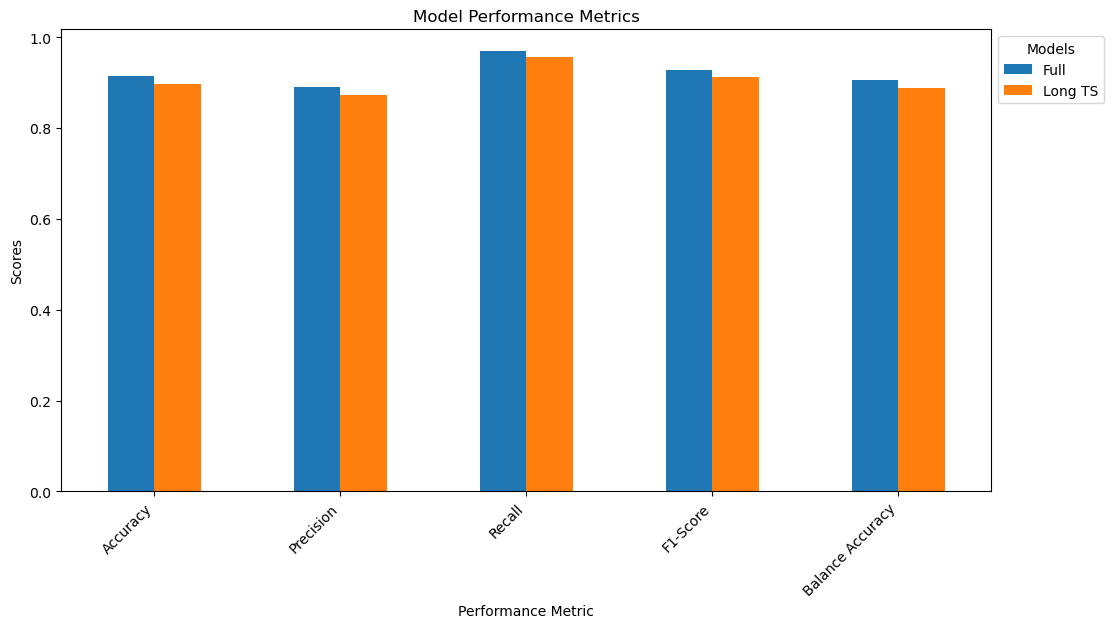

In [8]:
def create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full, performance_df_long_ts, random_seed
):
    """
    Creates a bar plot to compare the performance metrics of the full model and
    long timeseries model.
    Args:
    performance_df_full (pd.DataFrame): 
        the performance metrics for the full model
    performance_df_long_ts (pd.DataFrame): 
        the performance metrics for the long timeseries model
    random_seed (int or str): 
        if performance metrics from one random_seed then integer value of that seed,
        if performance metrics are averaged from many random_seeds then "average_score"
    """
    # Create a barplot comparing the scores of the two models
    performance_frames = [performance_df_full, performance_df_long_ts]
    concat_performance_df = pd.concat(performance_frames)
    
    concat_performance_df.index = ['Full', 'Long TS']
    concat_performance_df = concat_performance_df.T
    hue_list = concat_performance_df.index
    
    
    concat_performance_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Model Performance Metrics')
    plt.xlabel('Performance Metric')
    plt.ylabel('Scores')
    plt.xticks(ha='right', rotation=45)
    plt.legend(title='Models', loc='upper left', bbox_to_anchor=(1.0, 1.0))
    figpath = plotdir + '/performance_metrics'
    if isinstance(random_seed, int):
        figname = f'full_vs_long_ts_model_performance_metrics_for_seed{random_seed}.png'
    else:
        figname = f'full_vs_long_ts_model_performance_metrics_{random_seed}.png'
    plt.savefig(figpath + figname)
    plt.show()

create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full, performance_df_long_ts, 42
)

## Variable Importance

Variable Importances for full model:
 [0.04008497 0.08053933 0.13331424 0.0365764  0.27173665 0.06382332
 0.10536308 0.07058548 0.05537372 0.04262846 0.04558829 0.02564734
 0.02873872]

Negative Importance Indicators in full model:
 [False False False False False False False False False False False False
 False]

Variable Importances for long timeseries model:
 [0.04008497 0.08053933 0.13331424 0.0365764  0.27173665 0.06382332
 0.10536308 0.07058548 0.05537372 0.04262846 0.04558829 0.02564734
 0.02873872]

Negative Importance Indicators in long timeseries model:
 [False False False False False False False False False False False False
 False]


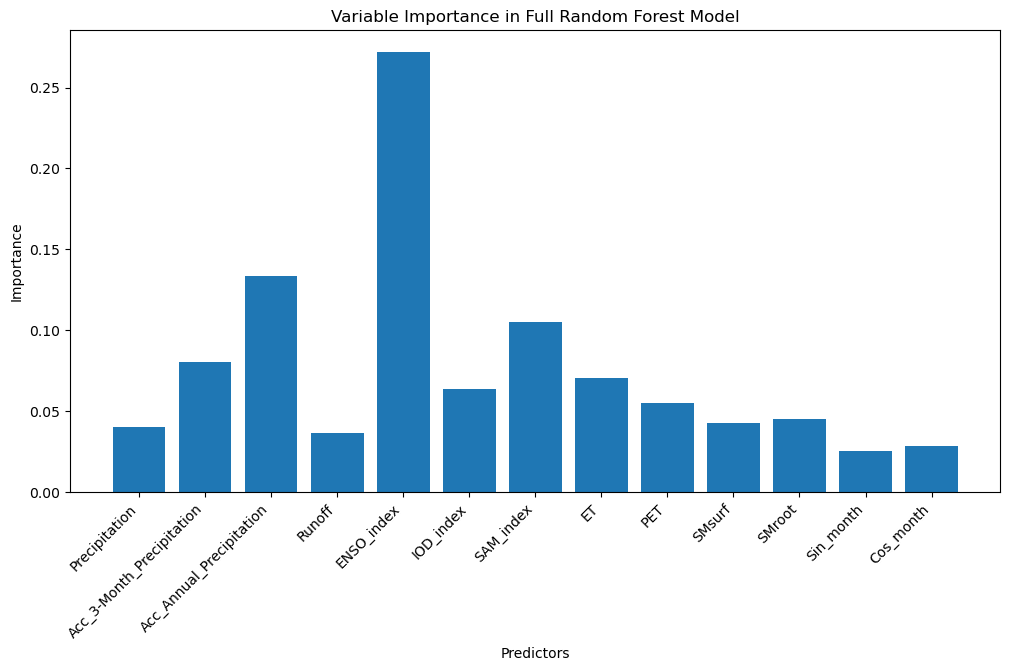

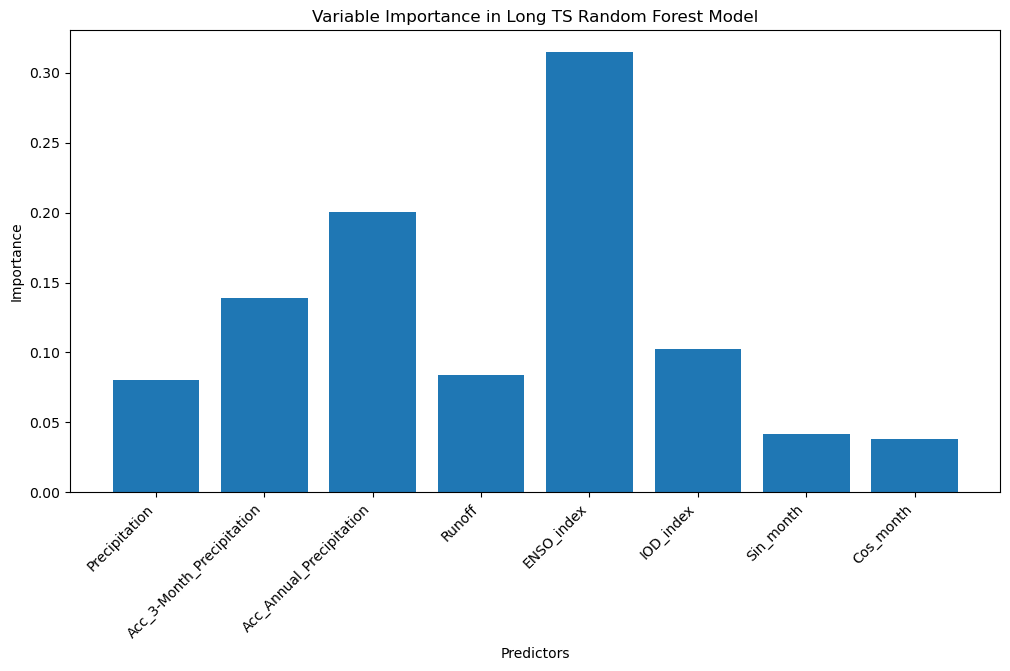

Ranking of predictors based on variable importance for full model:
                    Predictor  Variable Importance  Rank
0                  ENSO_index             0.271737     1
1    Acc_Annual_Precipitation             0.133314     2
2                   SAM_index             0.105363     3
3   Acc_3-Month_Precipitation             0.080539     4
4                          ET             0.070585     5
5                   IOD_index             0.063823     6
6                         PET             0.055374     7
7                      SMroot             0.045588     8
8                      SMsurf             0.042628     9
9               Precipitation             0.040085    10
10                     Runoff             0.036576    11
11                  Cos_month             0.028739    12
12                  Sin_month             0.025647    13

Ranking of predictors based on variable importance for long timeseries model:
                   Predictor  Variable Importance  Rank


In [9]:
# Calculate variable importance using the Random Forest model
variable_importance_full = clf_full.feature_importances_
variable_importance_long_ts = clf_long_ts.feature_importances_


# Check if any variable importances are negative
negative_importance_full = variable_importance_full < 0
negative_importance_long_ts = variable_importance_long_ts < 0

# Display variable importances and negative importance indicators
print("Variable Importances for full model:\n", variable_importance_full)
print("\nNegative Importance Indicators in full model:\n", negative_importance_full)

print("\nVariable Importances for long timeseries model:\n", variable_importance_full)
print("\nNegative Importance Indicators in long timeseries model:\n", negative_importance_full)

def create_variable_importance_barchart(variable_importance, X, model_type):
    """
    Plots barchart indicating each variables importances in the model
    Args:
    variable_importance (clf.feature_importance_): importance of each variable
    X: predictor variables
    model_type (str): either "full" or "long_ts"
    """
    model_title = {
        "full": "Full",
        "long_ts": "Long TS"
    }
    
    # Create a bar graph of variable importances
    plt.figure(figsize=(12, 6))
    plt.bar(X.columns, variable_importance)
    plt.xticks(ha='right', rotation=45)
    plt.xlabel('Predictors')
    plt.ylabel('Importance')
    plt.title(f'Variable Importance in {model_title[model_type]} Random Forest Model')
    figpath = plotdir + '/variable_importance/'
    figname = f'variable_importance_{model_type}_var_model.png'
    plt.savefig(figpath + figname)
    plt.show()

create_variable_importance_barchart(variable_importance_full, X_full, 'full')
create_variable_importance_barchart(variable_importance_long_ts, X_long_ts, 'long_ts')

# To display the ranking of the predictors
# Get the indices that would sort the variable importance array in descending order
sorted_indices_full = np.argsort(variable_importance_full)[::-1]
sorted_indices_long_ts = np.argsort(variable_importance_long_ts)[::-1]

# Create a DataFrame to display predictors and their rankings
ranking_df_full = pd.DataFrame({
    'Predictor': X_full.columns[sorted_indices_full],
    'Variable Importance': variable_importance_full[sorted_indices_full],
    'Rank': np.arange(1, len(X_full.columns) + 1)
})

ranking_df_long_ts = pd.DataFrame({
    'Predictor': X_long_ts.columns[sorted_indices_long_ts],
    'Variable Importance': variable_importance_long_ts[sorted_indices_long_ts],
    'Rank': np.arange(1, len(X_long_ts.columns) + 1)
})

# Print the ranking of predictors based on variable importance
print("Ranking of predictors based on variable importance for full model:")
print(ranking_df_full)

print("\nRanking of predictors based on variable importance for long timeseries model:")
print(ranking_df_long_ts)

## Multiple Iterations

Average Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.914591   0.890173  0.968553  0.927711          0.906408

Average Performance metrics for the long timeseires model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.896797   0.873563  0.955975  0.912913          0.887823


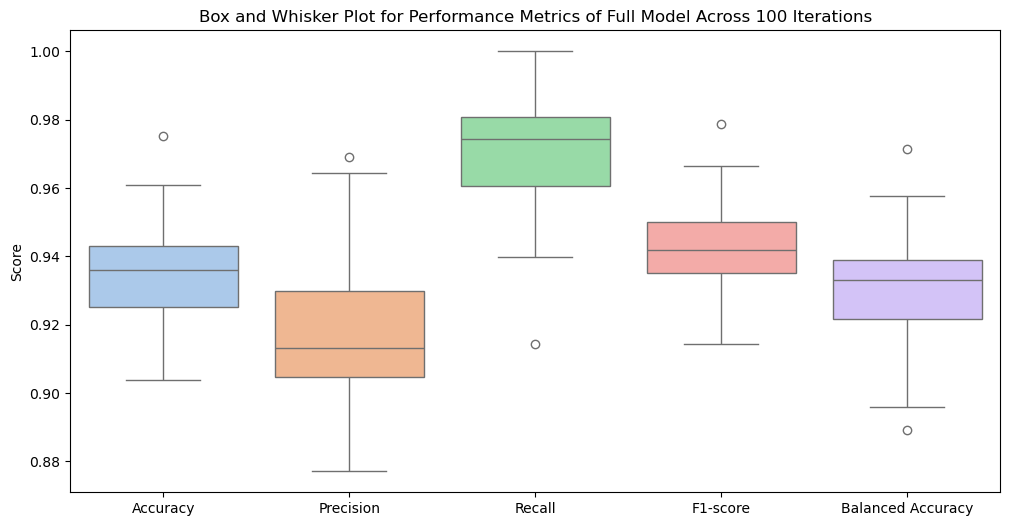

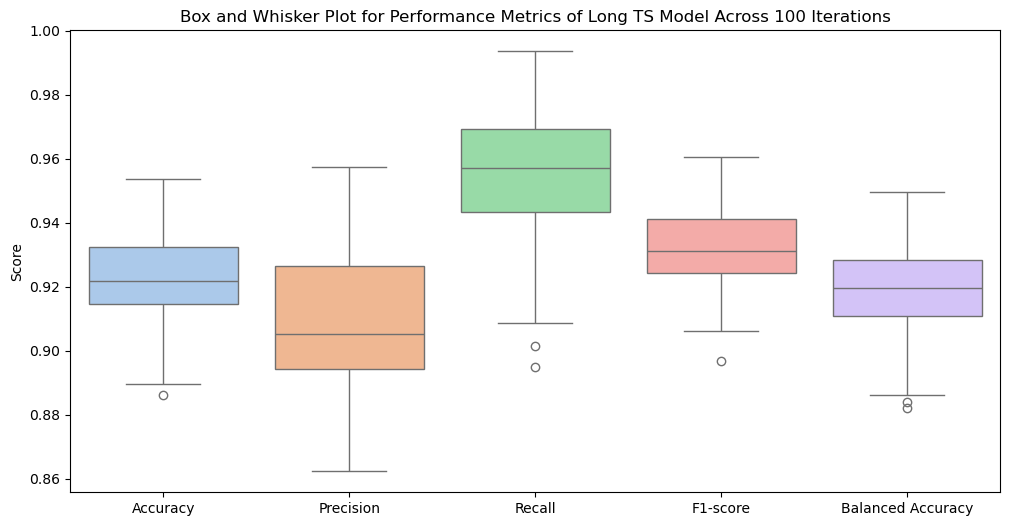

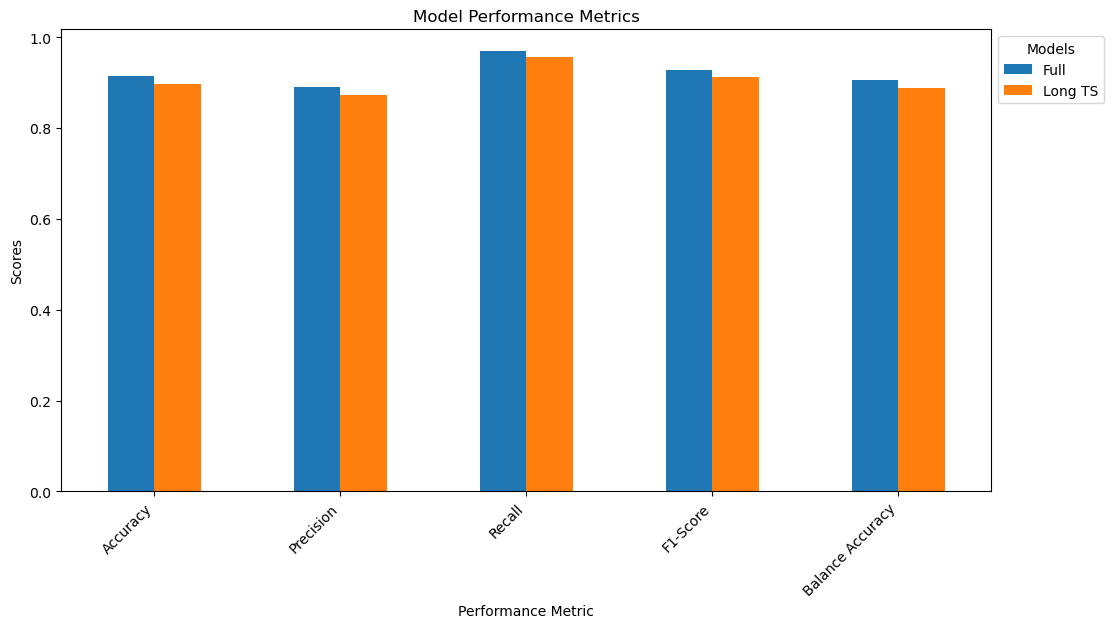

Average Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.914591   0.890173  0.968553  0.927711          0.906408

Average Performance metrics for the long timeseires model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy
0  0.896797   0.873563  0.955975  0.912913          0.887823


In [15]:
def performance_from_n_iterated_RF_model_seeds(X, y, test_size, n_iterations=100):
    """
    Trains the Random Forest with different seeds to assess stability and generalisability of the model.
    Args:
    X: predictor variables data
    y: target variables data
    test_size (float): proportion of data to be held back for testing
    n_iterations (int): number of iterations of model (default=100)
    """
    seeds = np.arange(n_iterations)
    
    # Initialize arrays to store performance metrics
    accuracy_scores = np.zeros(n_iterations)
    precision_scores = np.zeros(n_iterations)
    recall_scores = np.zeros(n_iterations)
    f1_scores = np.zeros(n_iterations)
    balanced_accuracy_scores = np.zeros(n_iterations)
    
    # Train the model and calculate performance metrics for each iteration
    for i, seed in enumerate(seeds):
        # Split the data into training and testing sets for each iteration
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
        # Train the Random Forest model with a different seed
        clf = RandomForestClassifier(n_estimators=100, random_state=seed)
        clf.fit(X_train, y_train)
    
        # Predict on test data
        y_pred = clf.predict(X_test)
    
        # Calculate performance metrics
        accuracy_scores[i] = accuracy_score(y_test, y_pred)
        precision_scores[i] = precision_score(y_test, y_pred)
        recall_scores[i] = recall_score(y_test, y_pred)
        f1_scores[i] = f1_score(y_test, y_pred)
        balanced_accuracy_scores[i] = balanced_accuracy_score(y_test, y_pred)
    
    # Create a DataFrame to store the performance metrics for each iteration
    performance_df = pd.DataFrame({
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-score': f1_scores,
        'Balanced Accuracy': balanced_accuracy_scores
    })

    return performance_df


def find_mean_performance_metrics(performance_df):
    """
    Find the mean of each performance metric.
    Args:
    performance_df (pd.DataFrame): 
        dataframe of the performance metrics from each iteration of the RF model
    """
    mean_performance_metric = performance_df.mean(axis=0)
    mean_performance_df = mean_performance_metric.to_frame().T
    
    return mean_performance_df
    

def create_performance_metrics_boxplot(performance_df, model_type):
    """
    Plots a boxplot of the performance metric scores
    Args:
    performance_df (pd.DataFrame): 
        dataframe of the performance metrics from each iteration of the RF model
    model_type (str): either "full" or "long_ts"
    """
    model_title = {
        "full": "Full",
        "long_ts": "Long TS"
    }
    
    # Draw a  box and whisker plot to display the results of each performance metric across 30 iterations
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=performance_df, palette="pastel")
    plt.ylabel('Score')
    plt.title(f'Box and Whisker Plot for Performance Metrics of {model_title[model_type]} Model Across 100 Iterations')
    figpath = plotdir + '/performance_metrics/'
    figname = f'performance_metric_boxplot_{model_type}_var_model.png'
    plt.show()


    
n_iterated_performance_df_full = performance_from_n_iterated_RF_model_seeds(X_full, y, 0.3)
n_iterated_performance_df_long_ts = performance_from_n_iterated_RF_model_seeds(X_long_ts, y, 0.3)

mean_performance_df_full = find_mean_performance_metrics(performance_df_full)
mean_performance_df_long_ts = find_mean_performance_metrics(performance_df_long_ts)

create_performance_metrics_boxplot(n_iterated_performance_df_full, "full")
create_performance_metrics_boxplot(n_iterated_performance_df_long_ts, "long_ts")

create_bar_chart_full_vs_long_ts_performance_metrics(
    mean_performance_df_full, mean_performance_df_long_ts, 'average_score'
)

print(f"Average Performance metrics for the full model are: \n{mean_performance_df_full}")
print(f"\nAverage Performance metrics for the long timeseires model are: \n{mean_performance_df_long_ts}")